In [1]:
from utils.features import *
import pandas as pd
import numpy as np
from keras import models, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras import metrics
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv('data/aus_open_matches_with_features.csv')

df = df.dropna()

df['diff_rank'] = df['player_1_rank'] - df['player_2_rank']

In [3]:
features_list = [
 'diff_rank',
 'diff_match_win_percent',
 'diff_games_win_percent',
 'diff_5_set_match_win_percent',
 'diff_close_sets_percent',
 'diff_match_win_percent_hard',
 'diff_games_win_percent_hard',
 'diff_5_set_match_win_percent_hard',
 'diff_close_sets_percent_hard',
 'diff_match_win_percent_60',
 'diff_games_win_percent_60',
 'diff_5_set_match_win_percent_60',
 'diff_close_sets_percent_60',
 'diff_match_win_percent_hard_100',
 'diff_games_win_percent_hard_100',
 'diff_5_set_match_win_percent_hard_100',
 'diff_close_sets_percent_hard_100',
 'diff_match_win_percent_hh',
 'diff_games_win_percent_hh',
 'diff_match_win_percent_hard_hh',
 'diff_games_win_percent_hard_hh']

In [4]:
target = df.result
features = df[features_list]

train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.20, random_state=1)

In [5]:
# Build the Neural Network

network = models.Sequential()
network.add(layers.Dense(units=64, activation='relu', input_shape=(len(features.columns),)))
network.add(layers.Dense(units=32, activation='relu'))
network.add(layers.Dense(units=1, activation='sigmoid'))

network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=500)
mc = ModelCheckpoint('model.h5', monitor='val_loss', mode='min', verbose=2, save_best_only=True)

history = network.fit(train_features, train_target, 
            epochs=1000, verbose=0, batch_size=128, 
            validation_data=(test_features, test_target), callbacks=[es, mc]) 

saved_model = load_model('model.h5')




Epoch 00001: val_loss improved from inf to 2.11003, saving model to model.h5

Epoch 00002: val_loss improved from 2.11003 to 0.88163, saving model to model.h5

Epoch 00003: val_loss did not improve from 0.88163

Epoch 00004: val_loss improved from 0.88163 to 0.80108, saving model to model.h5

Epoch 00005: val_loss improved from 0.80108 to 0.57185, saving model to model.h5

Epoch 00006: val_loss did not improve from 0.57185

Epoch 00007: val_loss improved from 0.57185 to 0.56243, saving model to model.h5

Epoch 00008: val_loss did not improve from 0.56243

Epoch 00009: val_loss improved from 0.56243 to 0.55622, saving model to model.h5

Epoch 00010: val_loss improved from 0.55622 to 0.55232, saving model to model.h5

Epoch 00011: val_loss improved from 0.55232 to 0.54785, saving model to model.h5

Epoch 00012: val_loss improved from 0.54785 to 0.53928, saving model to model.h5

Epoch 00013: val_loss improved from 0.53928 to 0.53590, saving model to model.h5

Epoch 00014: val_loss impro

In [6]:
# Accuracy of the best model
_, train_acc = saved_model.evaluate(train_features, train_target, verbose=0)
_, test_acc = saved_model.evaluate(test_features, test_target, verbose=0)

print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))



Train Accuracy: 0.766, Test Accuracy: 0.786


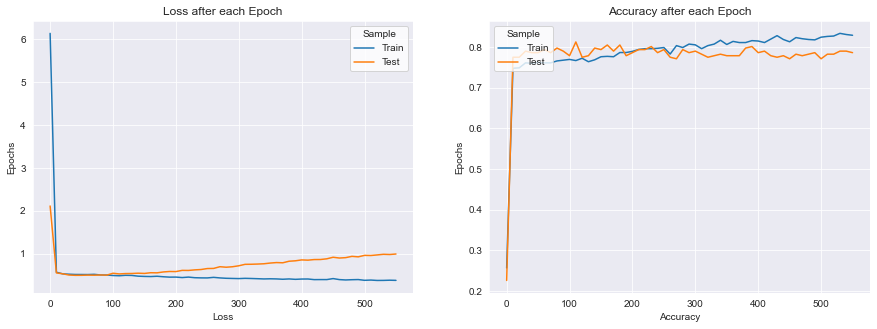

In [7]:
# Graph train/test loss and accuracy
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Loss after each Epoch')
plt.plot(history.epoch[::10], history.history['loss'][::10], label='Train')
plt.plot(history.epoch[::10], history.history['val_loss'][::10], label='Test')
plt.legend(['Train', 'Test'],loc='upper right', title='Sample', facecolor='white',fancybox=True)
plt.xlabel('Loss')
plt.ylabel('Epochs')

plt.subplot(1, 2, 2)
plt.title('Accuracy after each Epoch')
plt.plot(history.epoch[::10], history.history['accuracy'][::10], label='Train')
plt.plot(history.epoch[::10], history.history['val_accuracy'][::10], label='Test')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left', title='Sample', facecolor='white', fancybox=True)


plt.savefig('data/loss_acc.jpg', quality=100)

In [8]:
# Test data classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_target, saved_model.predict_classes(test_features)))
print(confusion_matrix(test_target, saved_model.predict_classes(test_features)))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       203
           1       0.75      0.14      0.24        63

    accuracy                           0.79       266
   macro avg       0.77      0.56      0.56       266
weighted avg       0.78      0.79      0.72       266

[[200   3]
 [ 54   9]]


C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if

In [9]:
# Trained data classification report and confusion matrix
print(classification_report(train_target, saved_model.predict_classes(train_features)))
print(confusion_matrix(train_target, saved_model.predict_classes(train_features)))

C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       792
           1       0.67      0.15      0.25       269

    accuracy                           0.77      1061
   macro avg       0.72      0.56      0.56      1061
weighted avg       0.75      0.77      0.71      1061

[[772  20]
 [228  41]]


In [10]:
# 2021 Australian Open

df_2021 = pd.read_csv('data/ausopen2021.csv')
df_raw = pd.read_csv('data/combined_raw_data.csv', low_memory=False)

df_2021['Date'] = '2021/02/15'
df_2021['Surface'] = 'Hard'
df_2021['diff_rank'] = df_2021['player_1_rank'] - df_2021['player_2_rank']

In [11]:
df_2021 = add_features(df_2021, df_raw)

Creating Player Career Stats All Surface
Creating Player Career Stats on Hard Court
Creating Player Career Stats All Surface Last 60 Weeks
Creating Player Career Stats on Hard Court Last 100 Weeks
Creating Player Head to Head Career Stats All Surface
Creating Player Head to Head Career Stats On Hard Court
Creating Difference Variables


In [12]:
# Model Predictions (0 means player_0 will win)
features_qtr = df_2021[features_list]

df_2021['prediction'] = saved_model.predict_classes(features_qtr)
df_2021['probability'] = 1 - np.abs(df_2021.prediction - saved_model.predict_proba(features_qtr).flatten())

first_prediction = df_2021[['Round', 'player_1', 'player_2', 'prediction', 'probability']]

C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\justi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [13]:
first_prediction.to_csv("test3.csv", index=False)